In [29]:
# Libraries needed
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

In [76]:
#read in data
df = pd.read_csv('/content/drive/My Drive/ACME-HappinessSurvey2020.csv')
df.head()
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


We see there are no missing or null values in the dataset. Now standardize the features to be on the same unit scale as Y [0,1], and add feautres Xmin, Xmax, and Xmean to the data:



In [97]:
num_features = len(df.columns)
X = df.drop(['Y'], axis=1)
Xnorm = (X - 1.0)/(4.0)
Xnorm['Xmin'] = Xnorm.min(axis=1)
Xnorm['Xmax'] = Xnorm.max(axis=1)
Xnorm['Xmean'] = Xnorm.mean(axis=1)
data = pd.concat([Xnorm, df['Y']], axis=1)
data.head()


,X1,X2,X3,X4,X5,X6,Xmin,Xmax,Xmean,Y
0,0.5,0.50,0.5,0.75,0.25,0.75,0.25,0.75,0.53125,0
1,0.5,0.25,0.5,1.00,0.75,0.50,0.25,1.00,0.59375,0
2,1.0,0.50,0.5,0.50,0.50,1.00,0.50,1.00,0.68750,1
3,1.0,0.75,0.5,0.50,0.50,1.00,0.50,1.00,0.71875,0
4,1.0,0.75,0.5,0.50,0.50,1.00,0.50,1.00,0.71875,0


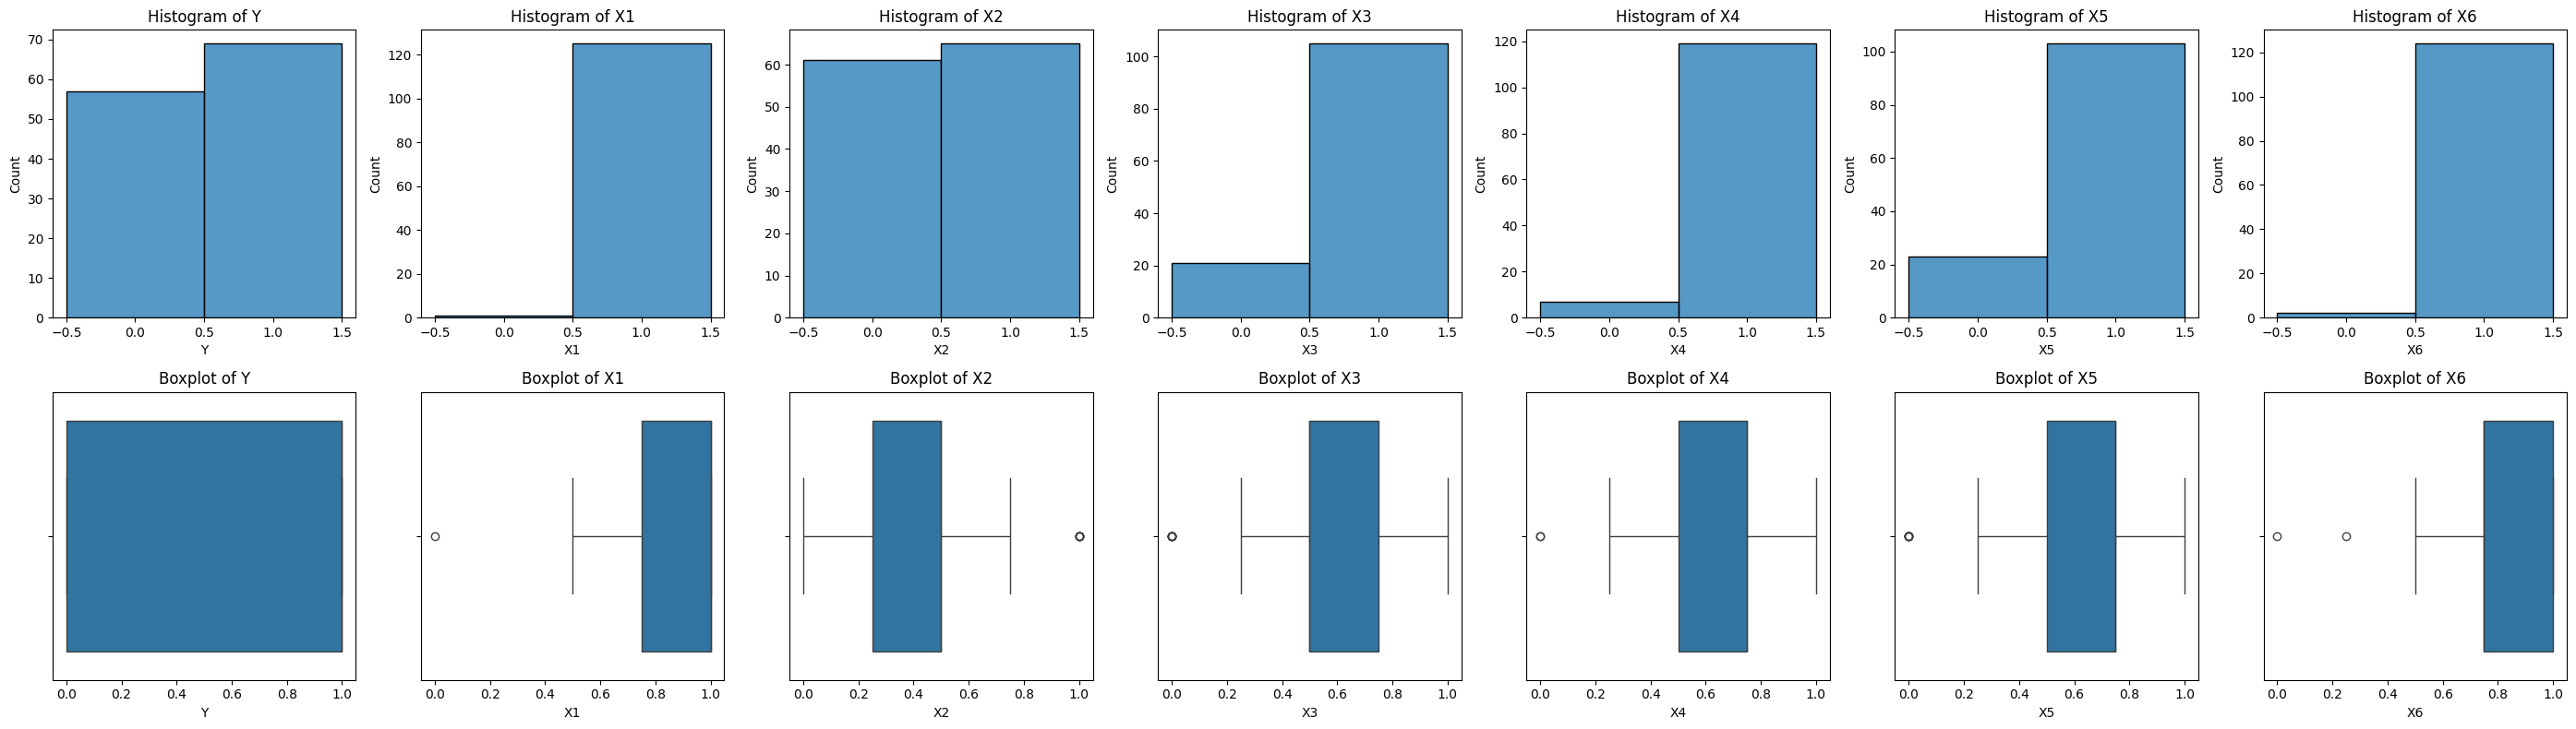

In [100]:
fig, axes = plt.subplots(2, num_features, figsize=(4*num_features, 8))

#Plot hist and boxplot of each original feature
for i, column in enumerate(df.columns):
    sns.histplot(data[column], discrete=True, ax=axes[0, i])
    axes[0, i].set_title(f'Histogram of {column}')
    sns.boxplot(x=data[column], ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

<Axes: >

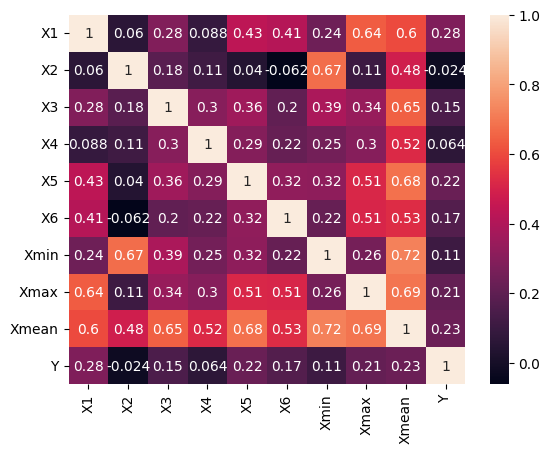

In [102]:
correlations = data.corr()
sns.heatmap(correlations, annot=True)

It looks like customer happiness correlates more with X1 and X5 than the other original features. This seems to suggest that customer satisfaction hinges on the experience with courier more than anything else (i.e., order content, price, and app experience). Xmax and Xmean (i.e., the highest score and average score a customer gives their orders) are better predictors of customer satisfaction than the minimum score Xmin. We'll remove the features with correlation coeffcients absolute values less than 0.2.


In [107]:
removed_features = correlations.loc[:, correlations.loc['Y'] < 0.2].columns

data1 = data.drop(removed_features, axis=1)
data1.head()


,X1,X5,Xmax,Xmean,Y
0,0.5,0.25,0.75,0.53125,0
1,0.5,0.75,1.00,0.59375,0
2,1.0,0.50,1.00,0.68750,1
3,1.0,0.50,1.00,0.71875,0
4,1.0,0.50,1.00,0.71875,0


# Model

We will use a Decision Tree classifier, as the data set is small and does not have complex relationships between features.

Train-test split:

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split


X = data1.drop('Y', axis=1)
y = data1['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)

In [112]:
S = GridSearchCV(estimator = DecisionTreeClassifier(random_state=13),
                 param_grid = {'max_depth': np.arange(1, 5), 'min_samples_split': np.arange(3, 5),'min_samples_leaf': np.arange(1, 5)})
S.fit(X_train, y_train)
model = S.best_estimator_
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('Model Evaluation on Train')
print(classification_report(y_train, y_pred_train))
print('Model Evaluation on Test')
print(classification_report(y_test, y_pred_test))


Model Evaluation on Train
              precision    recall  f1-score   support

           0       0.58      0.80      0.67        44
           1       0.78      0.55      0.65        56

    accuracy                           0.66       100
   macro avg       0.68      0.67      0.66       100
weighted avg       0.69      0.66      0.66       100

Model Evaluation on Test
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26

